In [149]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.stats import linregress
import os
from netCDF4 import Dataset
import matplotlib.ticker as mticker

#For plotting binned velocity profile
from scipy.stats import binned_statistic as bstats

In [150]:
# Import and apply style file for plots
plt.style.use("mpl.style")

# Functions
For any 2D or 3D Taylor-Vortex, calculate and compare LAMMPS kinetic energy and viscosity data to the analytical solution

In [151]:
#Calculate velocity from analytical solution to Taylor-Green Vortex
def vel_x_y_t(x,y,t,k_x,k_y,tau):
    u_x = -u_0*np.cos(k_x*x)*np.sin(k_y*y)
    u_y = u_0*np.sin(k_x*x)*np.cos(k_y*y)
    u_t = np.exp(-t/tau)
    return np.sum(np.abs(u_x), axis=1)*u_t , np.sum(np.abs(u_y), axis=1)*u_t

In [152]:
#Compile all filenames (value) and properties (key) into a dictionary
def generate_file_names(filepath):
    data_files = {}

    for file in os.listdir(filepath):

        #Remove the .nc extension
        #Collect the info for the run in an array
        file_info = file.split(".")
        file_info = file_info[0].split("_")

        #File name
        file_name = file

        #Add the files to datafiles dictionary
        data_files[(file_info[0],file_info[1],file_info[2])]= filepath + "/" + file_name
    return data_files



In [159]:
#Calculate values needed to plot kinetic energy decay
def data_KE(ds, mp, N):
    
    #Kinetic energy from data
    td = ds["time"][:]
    xd = ds['coordinates'][:,:,0] #At timestep nf, for all particles, x position
    yd = ds["coordinates"][:,:,1] #At timestep nf, for all particles, y position
    vxd = ds["velocities"][:,:,0] #At timestep nf, for all particles, x position
    vyd = ds['velocities'][:,:,1] #At timestep nf, for all particles, y velocity
    Exd = 0.5*mp*(np.sum(np.abs(vxd), axis=1))**2
    Eyd = 0.5*mp*(np.sum(np.abs(vyd), axis=1))**2
    E_tot = Exd+Eyd

    #Kinetic energy from analytic solution
    ref_vx, ref_vy = vel_x_y_t(xd,yd,td,k_x,k_y,tau) #Total velocity magnitude in x,y
    ref_Ex = 0.5*mp*(ref_vx)**2
    ref_Ey = 0.5*mp*(ref_vy)**2
    ref_E_tot = (ref_Ex + ref_Ey)

    return td, E_tot, ref_E_tot
#Calculate values needed to plot viscosity error
def calc_viscosity_error(td, E_tot, ref_E_tot):
    
    #Viscosity calculation from slope of semilogy(E_tot vs t)
    slope_d = linregress(td, np.log(E_tot/E_tot[0]))[0]
    nu_d = -slope_d/(2*(k_x**2+k_y**2)) #Kinematic viscosity from data
        
    #Viscosity calculation from analytical solution
    slope_ref = linregress(td, np.log(ref_E_tot/ref_E_tot[0]))[0]
    nu_ref = -slope_ref/(2*(k_x**2+k_y**2)) #Kinematic viscosity from data

    #Error
    nu_error = np.abs(nu_ref-nu_d)
    
    return nu_error




In [160]:
#Benchmark by plotting kinetic energy decay and viscosity
def benchmark(data_files):
    
    fig, ax = plt.subplots(2,1,figsize=(10,15))
    all_run_info = []

    for run in data_files:
        run_info = list(run)[0:2]
        var_0 = run_info[0]
        var_1 = run_info[1]
        run_info[0]=var_0_key[var_0]
        run_info[1]=var_1_key[var_1]

        ds = Dataset(data_files[run])

        #Scaling variables
        sf = 1/int(list(run)[2]) #Scaling of unit cell
        L_z = h3*(d-2)*sf #Account for L_z if d=3
        n = 1/sf**d #Number density - number of particles per volume
        mp = rho/n #Mass of particles (density is constant)

        if d == 3:
            N = L_x*L_y*L_z/sf**d # Total number of atoms
        elif d == 2:
            N = L_x*L_y/sf**d 

        run_info.append(sf)
        
        #Calculate kinetic energy decay and plot it
        td, E_tot, ref_E_tot = data_KE(ds, mp, N)
        if sf == 0.2: #Only plot sf=0.1 runs
            ax[0].semilogy(td*u_0/L_x, E_tot/E_tot[0],
                           marker=plot_key[run_info[1]][0],
                           markevery=20,
                           markerfacecolor="None",
                           color=plot_key[run_info[1]][1],
                           label = run_info[1])

        #Calculate viscosity error
        nu_L1_norm = calc_viscosity_error(td, E_tot, ref_E_tot)/N
        run_info.append(nu_L1_norm)
        
        all_run_info.append(run_info)
    
    #Plot KE decay from analytical velocity profile
    ax[0].semilogy(td*u_0/L_x, ref_E_tot/ref_E_tot[0],
                   label = "Analytic",
                   color="red",
                   linestyle="--")
    
    #Format kinetic energy decay plot
    ax[0].set_ylabel(r"$\frac{E_k}{E_{k0}}$")
    ax[0].set_xlabel(r"$\frac{tu_0}{L}$")
    ax[0].set_xlim(right=0.3)
    ax[0].set_ylim(bottom = 1e-3)
    handles,labels = ax[0].get_legend_handles_labels()

    handles = [handles[3], handles[0], handles[2], handles[1], handles[4]]
    labels = [labels[3], labels[0], labels[2], labels[1], labels[4]]
    ax[0].legend(handles,labels,loc="lower left")
    
    #Plot viscosity error
    df = pd.DataFrame(all_run_info, columns=["var0","var1","sf","Viscosity Normalized L1"])
    df.sort_values(by=["sf","var1"], inplace=True)
    
    for i in df["var0"].unique():
        df_1 = df[df["var0"]==i]
        for j in df_1["var1"].unique():
            df_2 = df_1[df_1["var1"]==j]
            label = j
            ax[1].loglog(L_x/df_2["sf"],df_2["Viscosity Normalized L1"],
                         marker=plot_key[j][0],
                         markerfacecolor="None",
                         color=plot_key[j][1],
                         label=label)
            nu_error_slope = np.log(L_x/df_2["sf"]).corr(np.log(df_2["Viscosity Normalized L1"]))
            print("Slope " + "(" + label + ")" + " : " + str(nu_error_slope))
            #print(df_2)
            
    #Line with a slope of -2 for rerefence
    y_ref = [10e-5,10e-9]
    x_ref = [20,200]
    ax[1].loglog(x_ref,y_ref, 
                 color="red",
                 linestyle="--",
                 label="Slope = -4")

    

    #Format viscosity error plot
    ax[1].legend(loc="lower left")
    ax[1].set_ylabel(r"$\frac{L_1}{N}$")
    ax[1].set_xlabel(r"$\frac{L}{\Delta x}$")
    ax[1].set_xlim(10**0.9,10**2.5)
    
    
    plt.tight_layout()

# Test Cases

## 2D Taylor Green Vortex
* Variables:
    * var_0 = no-shifting/shifting
    * var_1 = quintic/RK

Slope (CRK0) : -0.9899060724867902
Slope (CRK1) : -0.9939528809032885
Slope (CRK2) : -0.9967737837618361
Slope (Quintic) : -0.9899060724867902


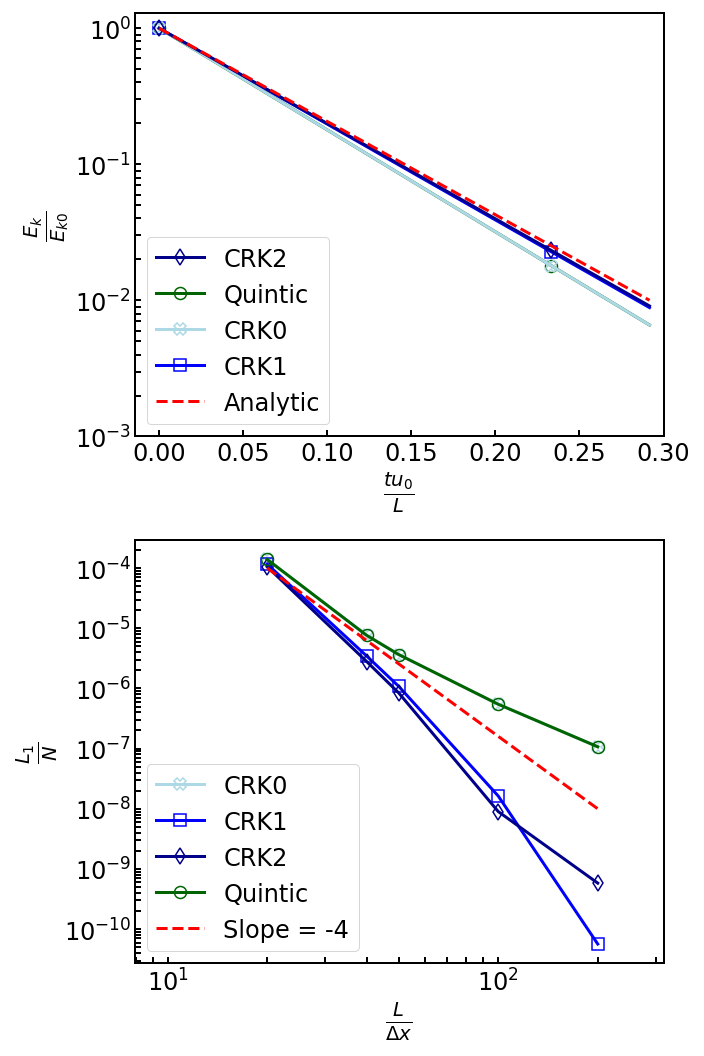

In [162]:
###Keys for stylizing the plot###
var_0_key = {"0":"Shifting Off","1":"Shifting On"} #Viscosity calc method
var_1_key = {"5":"Quintic","0":"CRK0", "1":"CRK1", "2":"CRK2"}
plot_key = {"Quintic":["o","darkgreen"],"CRK0":["X","lightblue"], "CRK1":["s","blue"],"CRK2":["d","darkblue"]}

###System Properties###
#System dimensions
d = 2
#Smoothing length coefficient
h3 = 3.5
#System size
L_x = 10 #Size of the system
L_y = L_x
#Fluid properties
rho = 1
#Oscillation properties
u_0 = 0.1
k_x = 2*np.pi/L_x
k_y = 2*np.pi/L_y
#Decay timescale
tau = 1/nu/(k_x**2+k_y**2)



###Data Files###
filepath = '/home/epalermo/dev/test/taylor_green_vortex/taylor_green_2D/data_files_current'
benchmark(generate_file_names(filepath))

## 3D Taylor Green Vortex
* 3D system with no initial velocity in the z direction
* Variables:
    * var_0 = no-shifting/shifting
    * var_1 = quintic/RK

In [90]:
###Keys for stylizing the plot###
var_0_key = {"0":["Shifting Off","blue"],"1":["Shifting On","green"]} #Viscosity calc method
var_1_key = {"5":["Quintic","."],"0":["CRK0","-."], "1":["CRK1","-"], "2":["CRK2","--"]}
kernel_marker_key = {"Quintic":".","CRK0":"-.", "1":["CRK1","-"], "2":["CRK2","--"]}
#sf_key = {0.05:"-",0.1:"--",0.2:"-.",0.25:":",0.5:(0,(5,10))}


###System Properties###
#System dimensions
d = 3
#Smoothing length coefficient
h3 = 3.5
#System size
L_x = 10 #Size of the system
L_y = L_x
#Fluid properties
eta = 0.01
rho = 1
nu = eta/rho
#Oscillation properties
u_0 = 0.1
k_x = 2*np.pi/L_x
k_y = 2*np.pi/L_y
#Decay timescale
tau = 1/nu/(k_x**2+k_y**2)

###Data Files###
#filepath = '/home/epalermo/dev/test/taylor_green_vortex/taylor_green_3D/data_files/variable_timestep'
#benchmark(generate_file_names(filepath))